<a href="https://colab.research.google.com/github/emgrande/Rn_hydrologic_tracer/blob/main/Euler_solver_GW_Influx_streams.ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# These codes use an Euler solver to calculate groundwater influx to streams from measured $^{222}Rn$ activity in surface water

We thank David Dralle for help writing these codes in Python


In [ ]:
#load the necesary libraries
library(tidyverse)

Load the data (these data was published in Avery et al. (2018))

In [ ]:
data <- read_csv("https://raw.githubusercontent.com/emgrande/Rn_hydrologic_tracer/main/martis_creek.csv")

Inspect the data

In [ ]:
head(data)

dist_m,Rn_pCiL,Rn_err
<dbl>,<dbl>,<dbl>
0.00,168.74,17.14
18.72,156.28,16.61
90.81,131.98,15.43
132.97,124.22,15.07
146.27,112.60,14.48
163.26,122.57,15.12


Define the variables (from Table 3 in Avery et al. (2018))

In [ ]:
#define constants
C0 <- 165 #Initial Rn conc [pCi/L]
Q0 <- 3570 #Initial discharge [m^3/d]
w <- 3.50 #stream size [m]
k <- 2.90 #Gas Transfer velocity [m/d]
Ci <- 400 #Groundwater Rn activity [pCi/L]
Io <- 0 #Initial GW input
E <- 0. #Evaporation

Observed/measured data

In [ ]:
x <- data$dist_m
C <- data$Rn_pCiL

#remove any NA
na <- is.na(x)
x <- x[!na]
C <- C[!na]

In [ ]:
#Spatial step and solution grid
dx <- 20 #[m]
xj <- seq(0, max(x), by = dx)

Solve given groundwater Influx ($I_j$)

In [ ]:
solver <- function(Ij){
  Q <- cumsum(Ij)*dx + Q0
  Cj <- rep(0,length(xj))
  Cj[1] <- C0
  #forward euler
  for (j in 2:length(Cj)) {
    dC <- dx*(Ij[j]*(Ci - Cj[j-1]) - k*w*Cj[j-1])/Q[j] - E*w*Cj[j-1]
    Cj[j] <- Cj[j-1] + dC
  }
  # get solution at observation points and return
  sol <- approxfun(xj, Cj, rule = 2,method = "const", f = 0.5)
  sol <- sol(x)
  return(sol)
}

We will use Nash–Sutcliffe effificency to calculate the model error

In [ ]:
nse <- function(target,prediction){
  numerator <- (target - prediction)^2
  denominator <- (target - mean(prediction, na.rm = T))^2
  return(1 - (sum(numerator, na.rm = T)) / 
                (sum(denominator, na.rm = T)))
}

Error metri

In [ ]:
err <- function(Ij){
  sol <- solver(Ij)
  value_error <- -nse(C,sol)
  return(value_error)
}


Calculate the results

In [ ]:
result <- optim(rep(0.1,length(xj)), err, method = "L-BFGS-B", lower = rep(0,length(xj)),upper = rep(Inf,length(xj)))

Ix <- result$par

Cn <- solver(Ix)

Plot the data

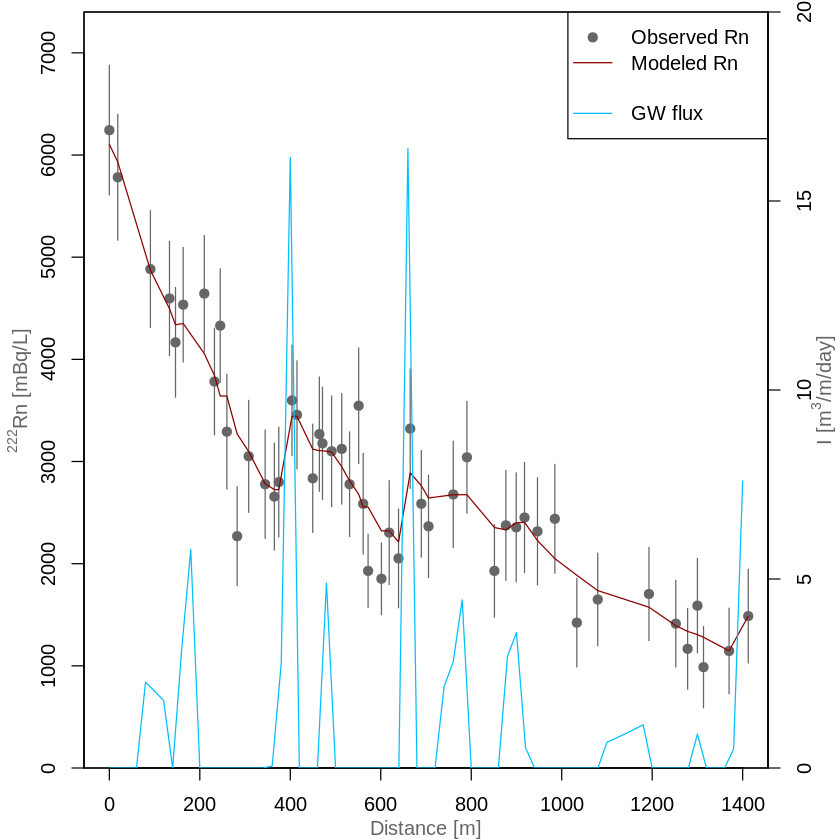

In [ ]:
#the original data is in pCi/L, convert to mBq

Rn_mBq <- data$Rn_pCiL *37
Rn_mBq_err <- data$Rn_err*37

par(mar = c(3,3.5,0.5,3), oma = c(0,0,0,0))

plot(data$dist_m,Rn_mBq, pch = 19, ylab = "", xlab = "", 
     col = "grey40", type = "n", xlim = c(0,1400),
     ylim = c(0, 7400), yaxs = "i")
#abline(v = seq(0,1400, 100), col = "grey80")
segments(x0 = data$dist_m, y0 = Rn_mBq+Rn_mBq_err, y1 = Rn_mBq-Rn_mBq_err,lend = 2, col = "grey40")
cex <- (Rn_mBq-min(Rn_mBq, na.rm = T))/(max(Rn_mBq, na.rm = T)-min(Rn_mBq, na.rm = T))+ 0.1
points(data$dist_m,Rn_mBq, pch = 19, col = "grey40")
lines(Cn*37~x, col = "darkred")

mtext(expression(""^222*"Rn [mBq/L]"),2,line = 2, col = "grey40")
legend("topright", legend = c("Observed Rn", "Modeled Rn","","GW flux"), pch = c(19,NA,NA,NA),
       col = c("grey40","darkred","blue","deepskyblue"), lty = c(NA,1,NA,1))

par(new = T)
plot(Ix~xj, type = "n", col = "blue", xlab = "", ylab = "",
     yaxt = "n", xaxt = "n",yaxs ="i", 
     xlim = c(0,1400), ylim = c(0,20))
#abline(v = seq(0,1400, 100), col = "grey80")
lines(Ix~xj,col = "deepskyblue")
mtext(expression("I [m"^3*"/m/day]"), 4, line = 2, col = "grey40")
mtext("Distance [m]",1,line = 2, col = "grey40")
yaxt <- seq(0, 20, length.out = 5)
axis(4,yaxt)
